In [35]:
import torch
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image
import os
import csv
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors

In [64]:
def find_second_element(csv_file, dish_id):
    with open(csv_file, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            if row[0] == dish_id:
                return float(row[2]) 
    return None

In [95]:
model = resnet50(pretrained=True)
model.fc = torch.nn.Identity()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
image_feature_list = []
image_folder = "../data/nutrition5k_reconstructed/images"
stop = 100
x = os.listdir(image_folder)
ing_dict = {}

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path).convert('RGB')
    image_tensor = preprocess(image).unsqueeze(0)
    with torch.no_grad():
        features = model(image_tensor)
    image_feature_list.append(features)
    dishes = image_name.split(".")[0]
    ing_dict[dishes] = find_second_element("../data/nutrition5k_reconstructed/labels/labels.csv", dishes)
    stop -= 1
    if stop == 0:
        break

image_feature_list = torch.cat(image_feature_list, dim=0)
#image_feature_list.shape shape [10, 2048]
print(ing_dict)


/Users/zhenglinning/anaconda3/envs/csci2470/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zhenglinning/anaconda3/envs/csci2470/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'dish_1561492665': 93.0, 'dish_1564516429': 186.0, 'dish_1566316681': 122.0, 'dish_1567023161': 134.0, 'dish_1561577947': 424.0, 'dish_1562949467': 72.0, 'dish_1560453328': 264.0, 'dish_1559849537': 393.0, 'dish_1566838286': 145.0, 'dish_1559581356': 294.0, 'dish_1564428475': 370.0, 'dish_1566590566': 142.0, 'dish_1567537212': 238.0, 'dish_1565884766': 546.0, 'dish_1568047932': 55.0, 'dish_1566500963': 25.0, 'dish_1561577678': 104.0, 'dish_1564083508': 225.0, 'dish_1558629444': 39.0, 'dish_1556575700': 86.0, 'dish_1559846504': 233.0, 'dish_1560441529': 152.0, 'dish_1562873028': 320.0, 'dish_1565727791': 99.0, 'dish_1560802730': 64.0, 'dish_1560455090': 155.0, 'dish_1557853154': 57.0, 'dish_1560961202': 153.0, 'dish_1559240875': 203.0, 'dish_1560526408': 51.0, 'dish_1561392459': 275.0, 'dish_1559590005': 241.0, 'dish_1558719514': 430.0, 'dish_1565638478': 91.0, 'dish_1565711498': 229.0, 'dish_1558372771': 311.0, 'dish_1558468547': 34.0, 'dish_1560788384': 242.0, 'dish_1566402041': 446.

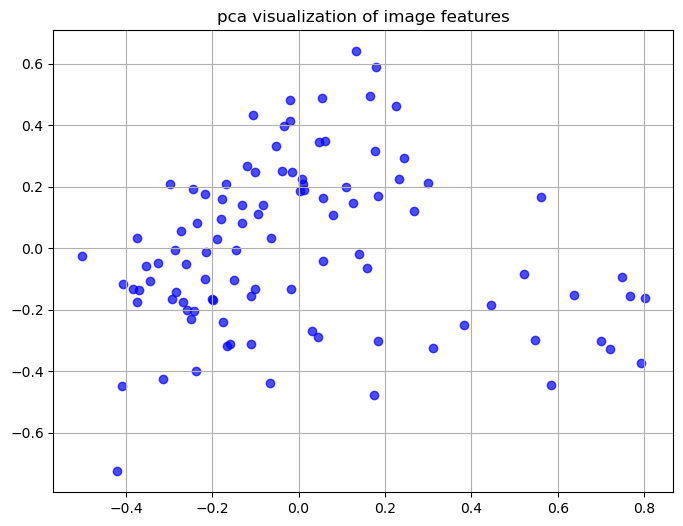

In [96]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_features(features):
    features_np = features.numpy()
    reducer = PCA(n_components=2)
    reduced_features = reducer.fit_transform(features_np)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', alpha=0.7)
    plt.title("pca visualization of image features")
    plt.grid(True)
    plt.show()
visualize_features(image_feature_list)


In [104]:
#similarity_matrix = cosine_similarity(image_feature_list.numpy())
k = 8
nbrs = NearestNeighbors(n_neighbors=k+1, metric="cosine").fit(image_feature_list.numpy())
distances, indices = nbrs.kneighbors(image_feature_list.numpy())
edges = [(i, neighbor) for i, neighbors in enumerate(indices) for neighbor in neighbors if i != neighbor]
edge_index = torch.tensor(edges, dtype=torch.long).T

print(f"Number of edges: {edge_index.size(1)}")

# threshold = 0.5
# edges = np.where(similarity_matrix > threshold)
# edge_index = torch.tensor(edges, dtype=torch.long)
dish_ids = ing_dict.keys()
masses = torch.tensor([ing_dict[dish_id] for dish_id in dish_ids], dtype=torch.float)
print("Edge Index:")
print(edge_index)



Number of edges: 800
Edge Index:
tensor([[ 0,  0,  0,  ..., 99, 99, 99],
        [27, 87, 74,  ..., 10,  1, 45]])


In [105]:
data = Data(x=image_feature_list, edge_index=edge_index, y=masses)

In [122]:
class GATRegressor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GATRegressor, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.5)
        #self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=False)
        #self.gat3 = GATConv(hidden_dim, output_dim, heads=1, concat=False)
        self.gat2 = GATConv(hidden_dim * heads, output_dim, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.relu(x)
        x = self.gat2(x, edge_index)
        # x = F.relu(x)
        # x = self.gat3(x, edge_index)
        return x.squeeze()
    
# Initialize the model
input_dim = image_feature_list.size(1)
hidden_dim = 2048
output_dim = 1
model = GATRegressor(input_dim, hidden_dim, output_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
loss_fn = torch.nn.L1Loss()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    out = model(data.x, data.edge_index)

    # Compute loss
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 195.56858825683594
Epoch 2, Loss: 3150.9541015625
Epoch 3, Loss: 902.9081420898438
Epoch 4, Loss: 5178.75146484375
Epoch 5, Loss: 876.4109497070312
Epoch 6, Loss: 306.2793884277344
Epoch 7, Loss: 384.61212158203125
Epoch 8, Loss: 372.6307373046875
Epoch 9, Loss: 219.1031494140625
Epoch 10, Loss: 489.13848876953125
Epoch 11, Loss: 188.34739685058594
Epoch 12, Loss: 169.36915588378906
Epoch 13, Loss: 186.0669403076172
Epoch 14, Loss: 192.7566375732422
Epoch 15, Loss: 175.6277313232422
Epoch 16, Loss: 161.1579132080078
Epoch 17, Loss: 147.89601135253906
Epoch 18, Loss: 201.72093200683594
Epoch 19, Loss: 149.0596466064453
Epoch 20, Loss: 194.50828552246094
Epoch 21, Loss: 187.34658813476562
Epoch 22, Loss: 202.82452392578125
Epoch 23, Loss: 255.33615112304688
Epoch 24, Loss: 186.26397705078125
Epoch 25, Loss: 173.73233032226562
Epoch 26, Loss: 253.46902465820312
Epoch 27, Loss: 184.3241424560547
Epoch 28, Loss: 163.0471649169922
Epoch 29, Loss: 161.28277587890625
Epoch 30, L

In [108]:
model.eval()
with torch.no_grad():
    predicted_mass = model(data.x, data.edge_index)
    print(f"Predicted Masses: {predicted_mass.tolist()}")
    print(f"True Masses: {data.y.tolist()}")

Predicted Masses: [245.94618225097656, 247.2512664794922, 245.81822204589844, 246.89450073242188, 248.37803649902344, 245.64486694335938, 247.08180236816406, 245.98475646972656, 246.31719970703125, 247.80645751953125, 250.30250549316406, 246.7881317138672, 247.3437957763672, 246.5478973388672, 246.73294067382812, 247.55746459960938, 246.3970489501953, 247.19171142578125, 247.51515197753906, 247.63558959960938, 245.98475646972656, 246.86619567871094, 247.6549530029297, 247.2899627685547, 246.37010192871094, 249.18833923339844, 243.00242614746094, 246.64759826660156, 247.37049865722656, 246.94920349121094, 246.433349609375, 247.39256286621094, 247.6775360107422, 246.6934356689453, 246.59840393066406, 246.98037719726562, 247.5151824951172, 245.50205993652344, 248.7618408203125, 247.3438720703125, 247.9915008544922, 247.65609741210938, 246.22430419921875, 246.38612365722656, 246.30455017089844, 247.95008850097656, 247.11492919921875, 247.6352996826172, 247.2387237548828, 247.4285125732422,

In [109]:
print(f"Number of edges: {edge_index.size(1)}")
print(f"Number of nodes: {image_feature_list.size(0)}")

Number of edges: 800
Number of nodes: 100


# New Approach

In [2]:
import pandas as pd
from collections import defaultdict
from itertools import combinations
from torch_geometric.nn import GCNConv, GATConv, BatchNorm

In [7]:
df = pd.read_csv("../utils/data/train_labels_ingr_id.csv")
df = pd.DataFrame.drop(df, labels="img_indx", axis=1)
df

,id,brown rice,quinoa,olive oil,carrot,watermelon,raspberries,berries,cantaloupe,pineapple,...,pepperoni,orange with peel,mozzarella cheese,baby carrots,banana with peel,wheat bread,chilaquiles,pasta salad,balsamic vinegar,toast
0,dish_1562699612,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dish_1558722322,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dish_1561406762,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dish_1562007739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dish_1562689548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2750,dish_1559933793,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2751,dish_1563389153,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2752,dish_1558725253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2753,dish_1561749348,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
num_rows, num_cols = df.shape
print(f"Number of rows: {num_rows}, Number of columns: {num_cols - 1}")
zero_columns = df.columns[(df == 0).all()]
print(zero_columns.tolist())

Number of rows: 2755, Number of columns: 199
['bread', 'tuna salad']


In [28]:
co_occurrence = defaultdict(int) # dict of tuples of ingredients and their co-occurrence, key: (ing1, ing2), value: count
ing_cols = df.columns.drop("id") # length should be 199
for _, r in df.iterrows():
    mask = r[ing_cols] == 1 # mask will be true for all the ingredients present in the matrix, false otherwise
    ing_present = ing_cols[mask].tolist() # ing_present is a list of ingredient present in the above matrix
    for first, second in combinations(ing_present, 2):
        food_pair = tuple(sorted([first, second]))
        co_occurrence[food_pair] += 1

In [33]:
all_ingredients = set()
for ing1, ing2 in co_occurrence.keys():
    all_ingredients.add(ing1)
    all_ingredients.add(ing2)

all_ingredients = list(all_ingredients) # list of all the ingredients
print(f"Number of ingredients: {len(all_ingredients)}")

ingredient_to_index = {ing: i for i, ing in enumerate(all_ingredients)}
print(ingredient_to_index)
print("co-oc", co_occurrence)
edge_list = []
for (ing1, ing2), weight in co_occurrence.items():
    edge_list.append((ingredient_to_index[ing1], ingredient_to_index[ing2], weight))
print(edge_list) # list of tuples of ingredients and their co-occurrence
edges_df = pd.DataFrame(edge_list, columns=["source", "target", "weight"]) # bidirectional edges
edges_df

Number of ingredients: 193
{'tortilla chips': 0, 'eggs': 1, 'blue cheese': 2, 'salsa': 3, 'lime': 4, 'orange juice': 5, 'spinach (cooked)': 6, 'berries': 7, 'almonds': 8, 'ginger': 9, 'garlic': 10, 'greek salad': 11, 'tomatillo': 12, 'corn on the cob': 13, 'soy sauce': 14, 'asparagus': 15, 'olives': 16, 'celery root': 17, 'kimchi': 18, 'pesto': 19, 'cranberries': 20, 'chilaquiles': 21, 'brownies': 22, 'pears': 23, 'deprecated': 24, 'raisins': 25, 'brown rice': 26, 'beets': 27, 'carrot': 28, 'lemon juice': 29, 'cilantro': 30, 'chicken apple sausage': 31, 'mozzarella cheese': 32, 'blueberries': 33, 'turnips': 34, 'chicken thighs': 35, 'mandarin oranges': 36, 'cottage cheese': 37, 'vegetable oil': 38, 'chard': 39, 'goat cheese': 40, 'chicken salad': 41, 'hominy': 42, 'black beans': 43, 'sweet potato': 44, 'salmon': 45, 'beef': 46, 'raspberries': 47, 'pepper': 48, 'mayonnaise': 49, 'wheat berry': 50, 'cheese': 51, 'cereal': 52, 'pepperoni': 53, 'country rice': 54, 'cauliflower': 55, 'kale'

,source,target,weight
0,26,58,11
1,26,84,187
2,84,58,119
3,28,84,279
4,84,135,1156
...,...,...,...
6355,7,59,1
6356,75,91,1
6357,189,75,1
6358,21,84,1


In [42]:
# Assuming edges_df is your DataFrame with 'weight' column
# Example:
# edges_df = pd.DataFrame({
#     'source': [0, 1, 2],
#     'target': [1, 2, 3],
#     'weight': [10, 20, 30]
# })

# Step 1: Identify the minimum and maximum weight values
weight_min = edges_df['weight'].min()
weight_max = edges_df['weight'].max()

# Step 2: Apply min-max normalization
edges_df['weight_normalized'] = (edges_df['weight'] - weight_min) / (weight_max - weight_min)

# Verify the normalization
print(edges_df.head())


   source  target  weight  weight_normalized
0      26      58      11           0.008658
1      26      84     187           0.161039
2      84      58     119           0.102165
3      28      84     279           0.240693
4      84     135    1156           1.000000


In [43]:
edge_index = torch.tensor([edges_df["source"].values, edges_df["target"].values], dtype=torch.long)
edge_weight = torch.tensor(edges_df["weight_normalized"].values, dtype=torch.float)
edge_index.shape, len(edge_weight)

(torch.Size([2, 6360]), 6360)

In [44]:
ing_num_total = len(all_ingredients)
x = torch.eye(ing_num_total)
data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
data

Data(x=[193, 193], edge_index=[2, 6360], edge_attr=[6360])

In [60]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_dim):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, edge_dim=edge_dim, concat=True, dropout=0.3)
        self.gat2 = GATConv(hidden_dim, output_dim, edge_dim=edge_dim, concat=False)
        self.batch_norm = BatchNorm(hidden_dim)
        self.batch_norm2 = BatchNorm(output_dim)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.gat2(x, edge_index, edge_weight)
        x = self.batch_norm2(x)
        return x

def graph_embedding_training(model, graph, epochs=100, lr=0.0005):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(graph.x, graph.edge_index, graph.edge_attr)

        edge_pred = (out[graph.edge_index[0]] * out[graph.edge_index[1]]).sum(dim=1)
        # Compute loss
        loss = loss_fn(edge_pred, graph.edge_attr)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    return model

In [62]:
edge_dim = data.edge_attr.size(1) if data.edge_attr is not None and data.edge_attr.dim() > 1 else 1
model = GAT(ing_num_total, 128, 128, edge_dim)
model = graph_embedding_training(model, data, epochs=90, lr=0.0005)

Epoch 1, Loss: 2519.802001953125
Epoch 2, Loss: 2191.95947265625
Epoch 3, Loss: 1406.8472900390625
Epoch 4, Loss: 1661.1064453125
Epoch 5, Loss: 1310.3726806640625
Epoch 6, Loss: 1088.6103515625
Epoch 7, Loss: 597.6139526367188
Epoch 8, Loss: 705.3526611328125
Epoch 9, Loss: 705.9620361328125
Epoch 10, Loss: 176.8219757080078
Epoch 11, Loss: 529.0773315429688
Epoch 12, Loss: 606.5901489257812
Epoch 13, Loss: 839.428955078125
Epoch 14, Loss: 373.1661071777344
Epoch 15, Loss: 310.28076171875
Epoch 16, Loss: 485.26708984375
Epoch 17, Loss: 706.1552124023438
Epoch 18, Loss: 467.981689453125
Epoch 19, Loss: 111.48533630371094
Epoch 20, Loss: 184.59970092773438
Epoch 21, Loss: 546.87548828125
Epoch 22, Loss: 245.75302124023438
Epoch 23, Loss: 207.1724395751953
Epoch 24, Loss: 254.54457092285156
Epoch 25, Loss: 508.3990173339844
Epoch 26, Loss: 263.78668212890625
Epoch 27, Loss: 327.8842468261719
Epoch 28, Loss: 239.09304809570312
Epoch 29, Loss: 297.3226013183594
Epoch 30, Loss: 58.890846252

In [195]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index)

print(f"Embeddings shape: {embeddings.shape}")


Embeddings shape: torch.Size([193, 128])
